In [2]:
!pip install qiskit qiskit-aer pylatexenc --quiet

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error  # (used in optional extensions)
from qiskit.visualization import (
    plot_bloch_multivector,
    plot_histogram,
    circuit_drawer
)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("✅ All required packages imported successfully. Qiskit environment ready.")


✅ All required packages imported successfully. Qiskit environment ready.


## **Task 1: Vary the number of qubits**



Running QFT for 2 qubits
--- QFT circuit for 2 qubits ---
                   ┌───┐    statevector 
q_0: ──────■───────┤ H ├─X───────░──────
     ┌───┐ │P(π/2) └───┘ │       ░      
q_1: ┤ H ├─■─────────────X───────░──────
     └───┘                       ░      


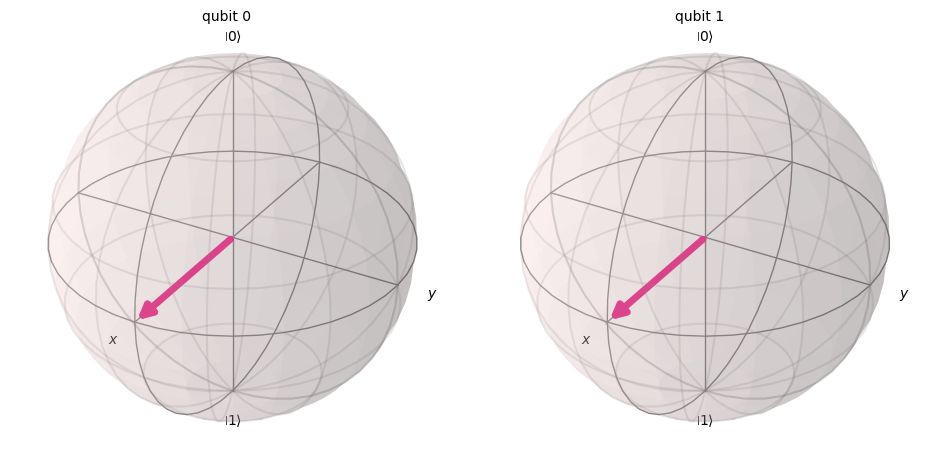


Running QFT for 3 qubits
--- QFT circuit for 3 qubits ---
                                          ┌───┐    statevector 
q_0: ──────■──────────────────────■───────┤ H ├─X───────░──────
           │                ┌───┐ │P(π/2) └───┘ │       ░      
q_1: ──────┼────────■───────┤ H ├─■─────────────┼───────░──────
     ┌───┐ │P(π/4)  │P(π/2) └───┘               │       ░      
q_2: ┤ H ├─■────────■───────────────────────────X───────░──────
     └───┘                                              ░      


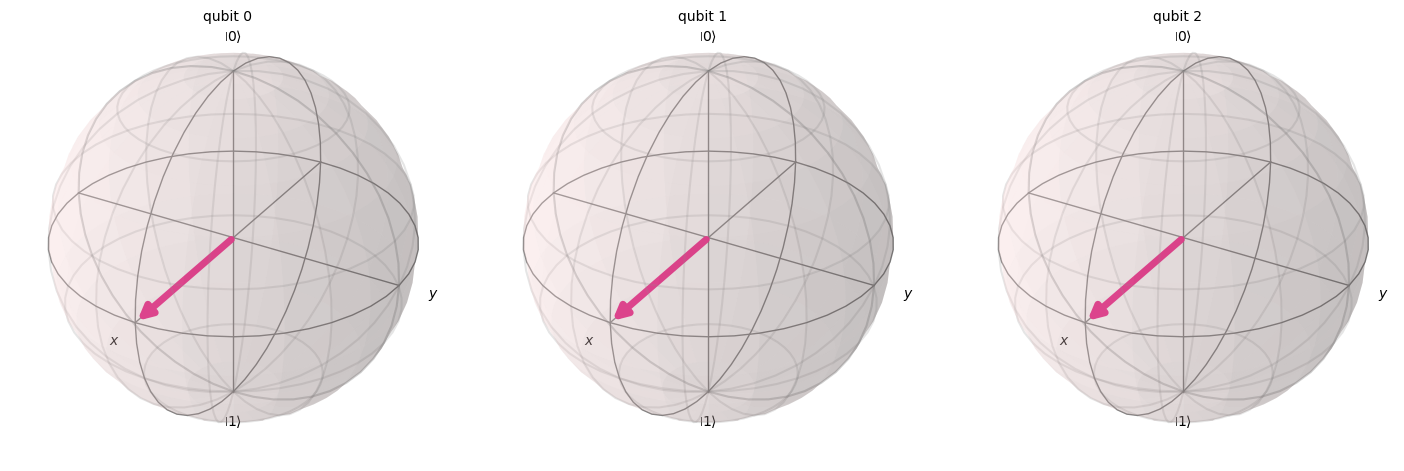


Running QFT for 4 qubits
--- QFT circuit for 4 qubits ---
                                                                          ┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │  »
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X──»
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     »
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────»
     └───┘                                                                     »
«         statevector 
«q_0: ─X───────░──────
«      │       ░      
«q_1: ─┼───────░──────
«      │       ░      
«q_2: ─┼───────░──────
«      │       ░      
«q_3: ─X───────░──────
«              ░      


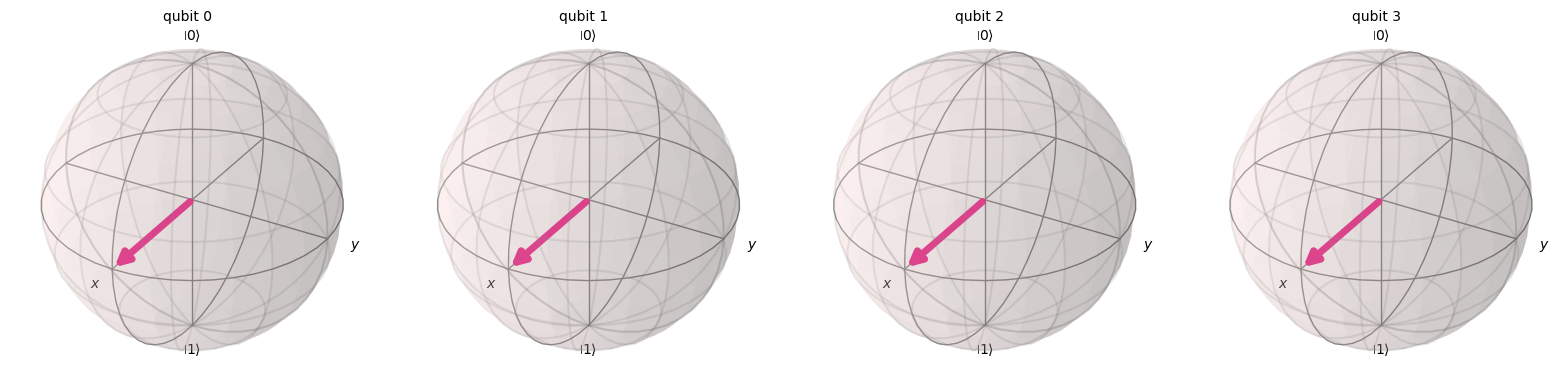

In [11]:
def qft_rot_pattern(circ, num_qubits):
    """Apply Hadamards and controlled-phase rotations recursively (renamed helper)."""
    if num_qubits == 0:
        return circ
    idx = num_qubits - 1
    circ.h(idx)
    for control in range(idx):
        angle = np.pi / (2 ** (idx - control))
        circ.cp(angle, control, idx)
    return qft_rot_pattern(circ, idx)

def reverse_bits(circ, num_qubits):
    """Swap qubits to reverse order (renamed)."""
    for q in range(num_qubits // 2):
        circ.swap(q, num_qubits - q - 1)
    return circ

def make_qft(n):
    """Construct an n-qubit QFT circuit (renamed builder)."""
    qc = QuantumCircuit(n)
    qft_rot_pattern(qc, n)
    reverse_bits(qc, n)
    qc.name = "QFT_n"
    return qc

def simulate_qft_and_show(n):
    qc = make_qft(n)
    sim = AerSimulator(method='statevector')
    qc.save_statevector()
    compiled = transpile(qc, sim)
    job = sim.run(compiled)
    res = job.result()
    st = res.data(0)["statevector"]
    print(f"--- QFT circuit for {n} qubits ---")
    print(qc.draw(output='text'))
    plot_bloch_multivector(st)
    plt.show()

# Try 2, 3 and 4 qubits
for nq in [2, 3, 4]:
    print(f"\nRunning QFT for {nq} qubits")
    simulate_qft_and_show(nq)


## **Task 2: Inverse QFT**

Combined QFT -> inverse QFT circuit:
     ┌────────┐┌──────────┐ statevector 
q_0: ┤0       ├┤0         ├──────░──────
     │        ││          │      ░      
q_1: ┤1 QFT_n ├┤1 QFT_inv ├──────░──────
     │        ││          │      ░      
q_2: ┤2       ├┤2         ├──────░──────
     └────────┘└──────────┘      ░      


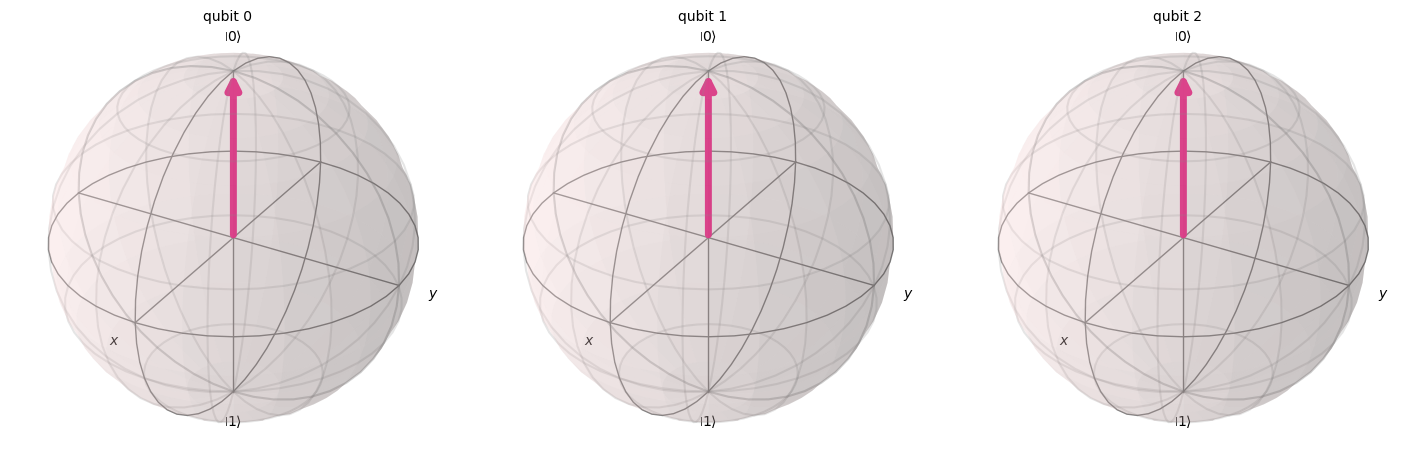

In [10]:
def qft_rotations_inverse(circ, n):
    """Apply inverse QFT rotations (negative angles, reversed order)."""
    if n == 0:
        return circ
    # we apply rotations in reverse of forward recursion: start from smallest index
    for i in range(n):
        # apply controlled-phase with negative angle (reverse direction)
        for control in range(i):
            angle = -np.pi / (2 ** (i - control))
            circ.cp(angle, control, i)
        circ.h(i)
    return circ

def inverse_qft_circuit(n):
    """Build the inverse QFT directly (without using .inverse()) to show structure."""
    qc = QuantumCircuit(n)
    # reverse swaps (same as forward swaps)
    reverse_bits(qc, n)
    # inverse rotations (note angles are negative and order reversed from forward)
    # The previous helper qft_rot_pattern did recursion forward; here we do explicit inverse pattern:
    for target in range(n):
        qc.h(target)
        for control in range(target):
            qc.cp(-np.pi / (2 ** (target - control)), control, target)
    qc.name = "QFT_inv"
    return qc

# sanity check: QFT followed by inverse QFT = identity (visual/state check)
n = 3
qft = make_qft(n)
qft_inv = inverse_qft_circuit(n)
combined = QuantumCircuit(n)
combined.append(qft.to_instruction(), range(n))
combined.append(qft_inv.to_instruction(), range(n))
combined.save_statevector()
sim = AerSimulator(method='statevector')
compiled = transpile(combined, sim)
res = sim.run(compiled).result()
sv = res.data(0)["statevector"]
print("Combined QFT -> inverse QFT circuit:")
print(combined.draw(output='text'))
# After applying QFT and its inverse to |0...0>, state should remain |0...0>
plot_bloch_multivector(sv)
plt.show()


## **Task 3: Integration with Phase Estimation**

Phase estimation counts (binary states of counting register):
{'111': 150, '101': 152, '011': 855, '001': 891}


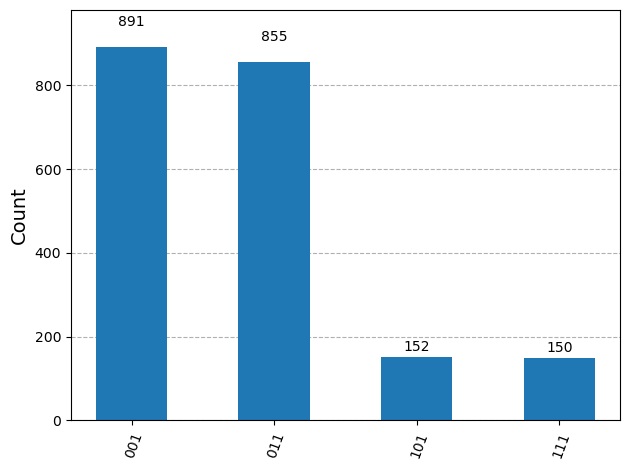


Circuit:
     ┌───┐                         ┌──────────┐┌─┐      
q_0: ┤ H ├─■───────────────────────┤0         ├┤M├──────
     ├───┤ │                       │          │└╥┘┌─┐   
q_1: ┤ H ├─┼────────■──────────────┤1 QFT_inv ├─╫─┤M├───
     ├───┤ │        │              │          │ ║ └╥┘┌─┐
q_2: ┤ H ├─┼────────┼────────■─────┤2         ├─╫──╫─┤M├
     ├───┤ │P(π/4)  │P(π/2)  │P(π) └──────────┘ ║  ║ └╥┘
q_3: ┤ X ├─■────────■────────■──────────────────╫──╫──╫─
     └───┘                                      ║  ║  ║ 
c: 3/═══════════════════════════════════════════╩══╩══╩═
                                                0  1  2 


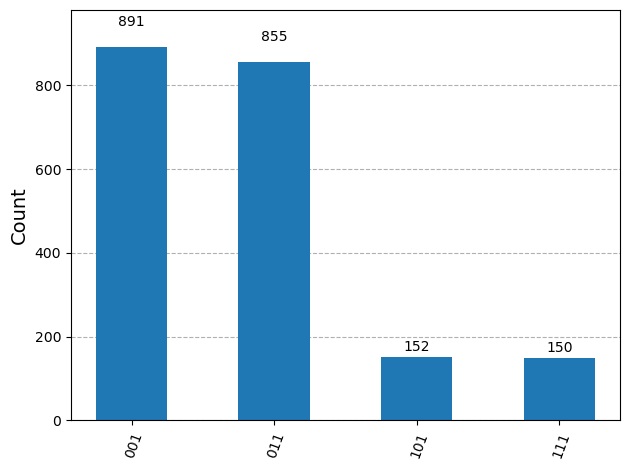

In [9]:
def controlled_phase_unitary(circ, target_qubit, phase):
    """Add a controlled-U where U = Rz(phase) on target (control handled outside)."""
    circ.rz(phase, target_qubit)

def phase_estimation_demo(num_counting_qubits=3, phase=np.pi/4):
    """
    Simple phase estimation:
    - counting register: num_counting_qubits
    - target register: 1 qubit initialized to |1> (an eigenstate of Rz)
    We use controlled Rz^2^k gates implemented as controlled-rz with scaled angle.
    """
    t = 1
    total_qubits = num_counting_qubits + t
    qc = QuantumCircuit(total_qubits, num_counting_qubits)

    # prepare target in eigenstate |1>
    qc.x(num_counting_qubits)  # target is the last qubit

    # Hadamards on counting qubits
    qc.h(range(num_counting_qubits))

    # controlled-U^{2^k}: here U = Rz(phase), so U^{2^k} = Rz(phase * 2^k)
    for k in range(num_counting_qubits):
        angle = phase * (2 ** k)
        ctrl = k
        tgt = num_counting_qubits
        # implement controlled-rz via cp (controlled phase on computational basis)
        qc.cp(angle, ctrl, tgt)

    # apply inverse QFT on counting register
    # build inverse QFT on first num_counting_qubits qubits
    inv_qft = inverse_qft_circuit(num_counting_qubits)
    # append it (as instruction) to the counting register (indices 0..num_counting_qubits-1)
    qc.append(inv_qft.to_instruction(), list(range(num_counting_qubits)))

    # measure counting register
    qc.measure(range(num_counting_qubits), range(num_counting_qubits))

    # simulate
    sim = AerSimulator()
    compiled = transpile(qc, sim)
    job = sim.run(compiled, shots=2048)
    res = job.result()
    counts = res.get_counts()
    print("Phase estimation counts (binary states of counting register):")
    print(counts)
    display(plot_histogram(counts))
    print("\nCircuit:")
    print(qc.draw(output='text'))

# Example: estimate phase = pi/4
phase_estimation_demo(num_counting_qubits=3, phase=np.pi/4)


## **Task 4: Measure Output States**

Measured distribution after QFT on 2 qubits:
{'01': 284, '00': 263, '10': 257, '11': 220}


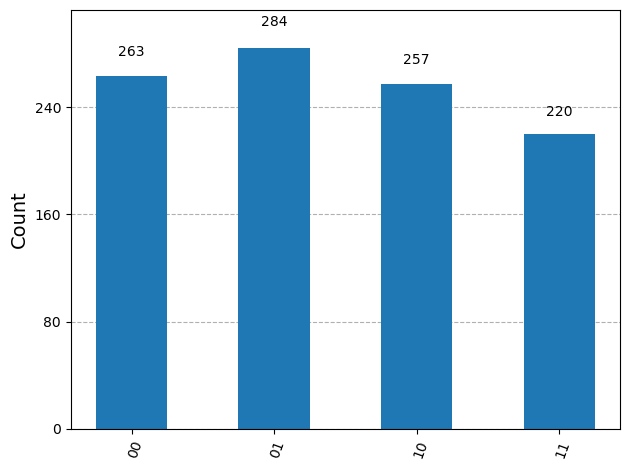


Circuit:
      ┌───┐ ░ ┌────────┐┌─┐   
q_0: ┤ X ├─░─┤0       ├┤M├───
     └───┘ ░ │  QFT_n │└╥┘┌─┐
q_1: ──────░─┤1       ├─╫─┤M├
           ░ └────────┘ ║ └╥┘
c: 2/═══════════════════╩══╩═
                        0  1 
Measured distribution after QFT on 3 qubits:
{'111': 135, '011': 108, '100': 115, '110': 115, '001': 143, '000': 139, '010': 157, '101': 112}


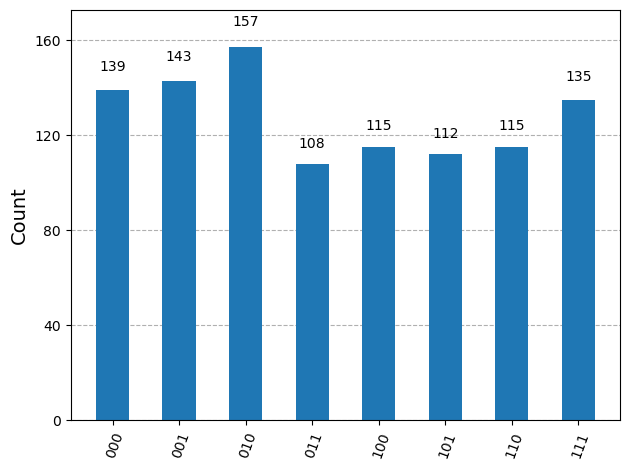


Circuit:
      ┌───┐ ░ ┌────────┐┌─┐      
q_0: ┤ X ├─░─┤0       ├┤M├──────
     └───┘ ░ │        │└╥┘┌─┐   
q_1: ──────░─┤1 QFT_n ├─╫─┤M├───
           ░ │        │ ║ └╥┘┌─┐
q_2: ──────░─┤2       ├─╫──╫─┤M├
           ░ └────────┘ ║  ║ └╥┘
c: 3/═══════════════════╩══╩══╩═
                        0  1  2 


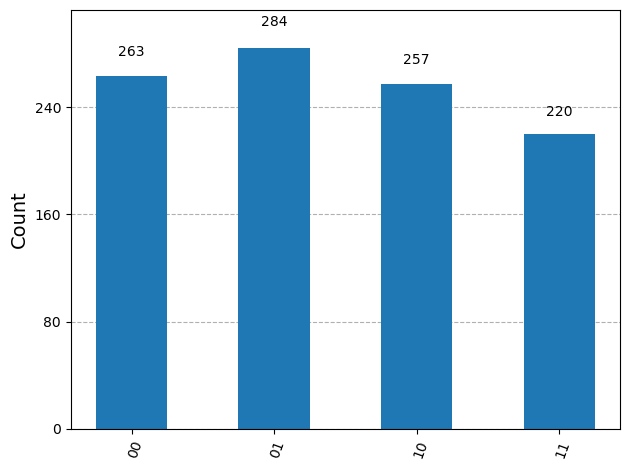

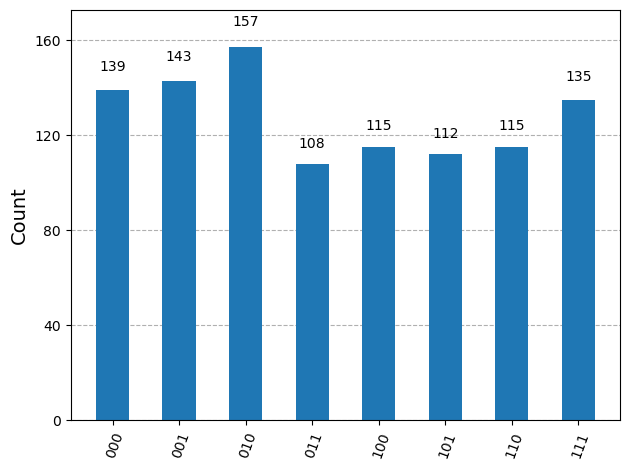

In [8]:
def qft_with_measure(n, shots=1024):
    qc = QuantumCircuit(n, n)
    qc.x(0) 
    qc.barrier()
    
    qft_sub = make_qft(n)
    qc.append(qft_sub.to_instruction(), list(range(n)))
    qc.measure(range(n), range(n))

    sim = AerSimulator()
    compiled = transpile(qc, sim)
    job = sim.run(compiled, shots=shots)
    res = job.result()
    counts = res.get_counts()
    print(f"Measured distribution after QFT on {n} qubits:")
    print(counts)
    display(plot_histogram(counts))
    print("\nCircuit:\n", qc.draw(output='text'))


qft_with_measure(2)
qft_with_measure(3)


## **Task 5: Circuit Visualization**

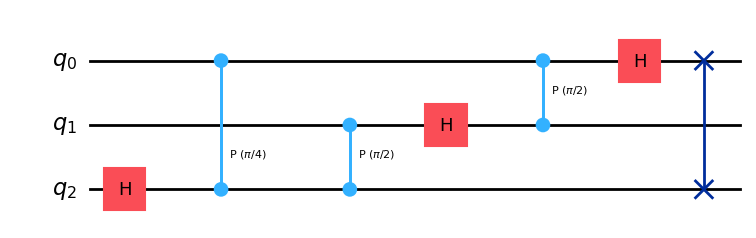

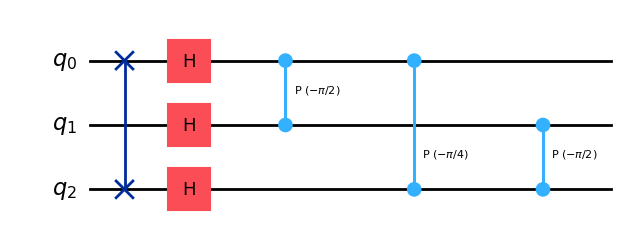

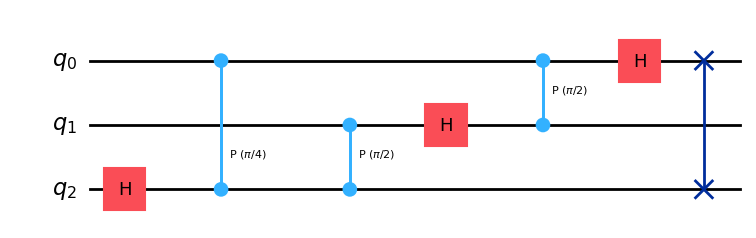

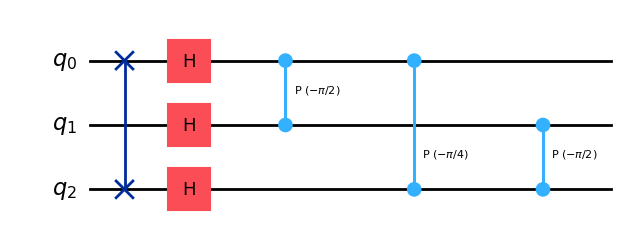

In [7]:
qc_qft = make_qft(3)
qc_qft_inv = inverse_qft_circuit(3)

fig1 = qc_qft.draw(output='mpl')
fig2 = qc_qft_inv.draw(output='mpl')

# display both (each is a matplotlib Figure)
display(fig1)
display(fig2)